In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf ##  Autocorrelation plot
from sklearn import preprocessing  ## for standardization 
import pystan_utils
import pystan
import seaborn as sns

In [2]:
df=pd.read_csv("./dataset/pickups+weather_wallstreet.csv")
df.head()

,datetime,pickups,date,min_temp,max_temp,wind_speed,wind_gust,visibility,pressure,precipitation,snow_depth,fog,rain_drizzle,snow_ice,thunder
0,2009-01-01 00,47,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
1,2009-01-01 01,74,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
2,2009-01-01 02,79,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
3,2009-01-01 03,57,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
4,2009-01-01 04,46,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0


### Data preparation

In [3]:
## data type
df.dtypes

datetime          object
pickups            int64
date              object
min_temp         float64
max_temp         float64
wind_speed       float64
wind_gust        float64
visibility       float64
pressure         float64
precipitation    float64
snow_depth       float64
fog                int64
rain_drizzle       int64
snow_ice           int64
thunder            int64
dtype: object

In [4]:
## Convert datetime column into datetime object
df["datetime"]=pd.to_datetime(df["datetime"],format="%Y-%m-%d")

## Adding columns with day of week(dow) and time of day(tod)
df["dow"]=df.datetime.dt.weekday
df["tod"]=df.datetime.dt.hour

## Adding time of day and day of week as dummy variables
dummy_week=pd.get_dummies(df["dow"])
dummy_hour=pd.get_dummies(df["tod"])
week_colName = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dummy_week.set_axis(week_colName, axis=1, inplace=True)

new_df=pd.concat([df, dummy_week,dummy_hour],axis=1).set_index("datetime").drop(["date","tod","dow"],axis=1)
print(new_df.shape)
print(new_df.columns)

(65712, 44)
Index([      'pickups',      'min_temp',      'max_temp',    'wind_speed',
           'wind_gust',    'visibility',      'pressure', 'precipitation',
          'snow_depth',           'fog',  'rain_drizzle',      'snow_ice',
             'thunder',        'Monday',       'Tuesday',     'Wednesday',
            'Thursday',        'Friday',      'Saturday',        'Sunday',
                     0,               1,               2,               3,
                     4,               5,               6,               7,
                     8,               9,              10,              11,
                    12,              13,              14,              15,
                    16,              17,              18,              19,
                    20,              21,              22,              23],
      dtype='object')


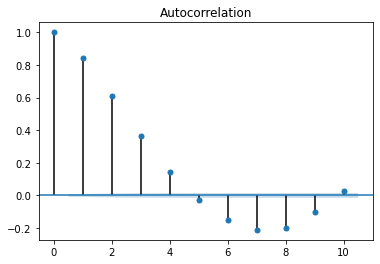

In [5]:
## Autocorrelation plot: how many lags should be included ...?
plot_acf(new_df.pickups,lags=10);

## Adding first and second lagged_pickups to the dataset
new_df["first_lag"]=new_df.pickups.shift(1)
new_df["second_lag"]=new_df.pickups.shift(2)
new_df.dropna(inplace=True)

In [6]:
new_df.shape

(65710, 46)

In [7]:
# Get column names first
names = new_df.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(new_df)
scaled_df = pd.DataFrame(scaled_df, columns=names)

In [8]:
## Predictors and target variable as matrix
X = scaled_df.drop("pickups",axis=1).values
y = scaled_df["pickups"].values.reshape(-1,1)


# Mean and standard deviation of pickups: to convert back to the orginal data
y_std = new_df.pickups.std()
y_mean = new_df.pickups.mean()

In [9]:
## The first 2/3 as train set and rest 1/3 as test set
N,D = X.shape
split = int(N*2/3)
X_train = X[:split,:]; X_test = X[split:, :]
y_train = y[:split]; y_test = y[split:]

In [10]:
# funciton for evaluating the quality of the predictions of a regression model (continuous output variables!)
def compute_error(trues, predicted):
    trues=trues.flatten()
    predicted=predicted.flatten()
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

### Plate notation

![title](PGM1.png)

### Stan model : Gaussian linear regression model

Time to implement Bayesian linear regression in STAN! 

Note: since the input matrix X does not include a column with all 1's, we need to model the intercept term explicitly! We therefore shall include a alpha variable (the intercept) in the model for this purpose. The likelihood of the model is then as follows:

$y_n \sim \mathcal{N}(\alpha + \boldsymbol\beta^T \textbf{x}_n , \sigma^2)$


In [16]:
## Method 1
STAN_reg_model = """
data {
    int<lower=1> N;                  // no. of data items
    int<lower=1> D;                  // no. of predictors
    vector[1] y[N];                  // target variable
    vector[D] X[N];                  // predictor matrix 
}
parameters {
    real sigma;                      // error scale
    real alpha;                      // intercept
    vector[D] beta;                  // coefficients for predictors 
}

model {    
    // Important: In STAN, the second parameter of “normal(0, 10)" is a standard
    // deviation and not a variance! So, the variance is actually 10^2 = 100
    alpha ~ normal(0,10);            // prior on the intercept
    beta ~ normal (0,10);            // prior on the coefficients
    sigma ~ inv_gamma(0.01,0.01);    // prior on the variance
    for (i in 1:N)                   // likelihood
        y[i] ~ normal(alpha + beta'*X[i,:],sigma);  
}

"""

# compile model
sm = pystan.StanModel(model_code = STAN_reg_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a2b4f628d871699133b2601c1209521b NOW.


In [17]:
## Method 2
# define Stan model
model_definition = """
data {
    int<lower=0> N; // number of data items
    int<lower=0> D; // number of predictors
    matrix[N,D] x;  // predictor matrix
    vector[N] y;    // outcome vector
}
parameters {
    real alpha;             // intercept
    vector[D] beta;         // coefficients for predictors
    real<lower=0> sigma;    // error scale
} 
model {
    alpha ~ normal(0,10);                        // prior on the intercept
    sigma ~ cauchy(0,10);                        // prior on the variance
    for (d in 1:D)
        beta[d] ~ normal(0,1);             // prior on the coefficients
    y ~ normal(alpha + x * beta, sigma);   // likelihood
}
"""
sm = pystan.StanModel(model_code = STAN_reg_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a2b4f628d871699133b2601c1209521b NOW.


We begin by doing inference on the model using MCMC (NUTS) and using only a small subsample of the dataset.

In [18]:
# prepare data for Stan model
X_train_small = X_train[:100,:]
y_train_small = y_train[:100]
N, D = X_train_small.shape
data = {'N': N, 'D': D, 'X': X_train_small, 'y': y_train_small}

In [19]:
%%time
# run inference
fit = sm.sampling(data=data, algorithm="NUTS", seed=0, chains=4, iter=1000, control={'max_treedepth': 50})

# show results
print(fit)

# extract samples
samples = fit.extract(permuted=True)

Inference for Stan model: anon_model_a2b4f628d871699133b2601c1209521b.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
sigma       0.22  5.6e-4   0.02   0.19   0.21    0.22   0.23   0.26   1069    1.0
alpha      -0.19    0.19   9.17 -18.89  -6.53    0.14   6.19  18.14   2260    1.0
beta[1]      0.1    0.18    9.0 -17.92  -5.74    0.05   5.92  18.23   2486    1.0
beta[2]    -0.07    0.15   8.42 -17.01  -5.55    0.11   5.25   16.3   3043    1.0
beta[3]    -0.13    0.17    8.6 -16.82  -6.09   -0.19   5.55  17.09   2473    1.0
beta[4]    -0.18    0.17   7.66 -15.13  -5.37   -0.24   4.82  15.57   1945    1.0
beta[5]     0.05    0.19   9.43 -17.23  -6.77 -9.9e-3   6.64   18.1   2523    1.0
beta[6]     0.34    0.19   9.91 -18.65  -6.36    0.47   7.09  19.57   2644    1.0
beta[7]    -0.08    0.19  10.09 -19.15  -7.01   -0.29   6.47  20.48   2957 

Plot the posterior distribution of some of the latent variables in the model (alpha, betas and sigma)

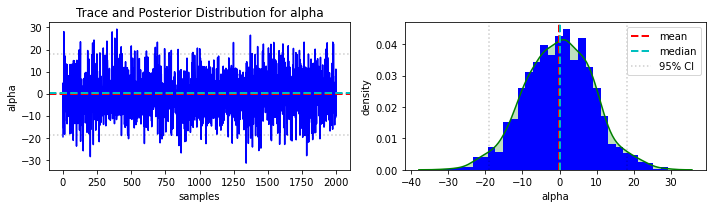

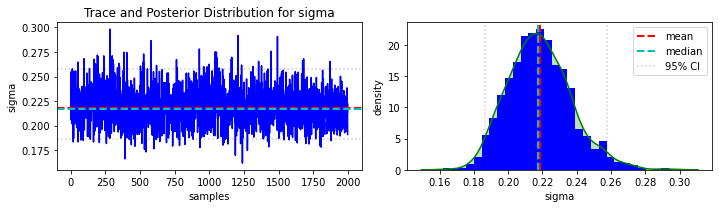

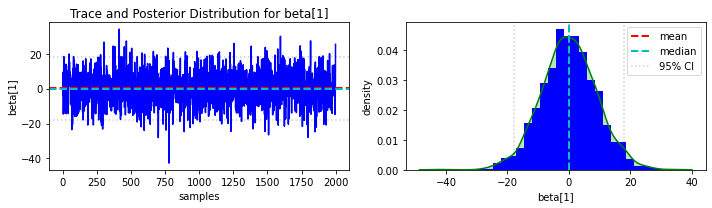

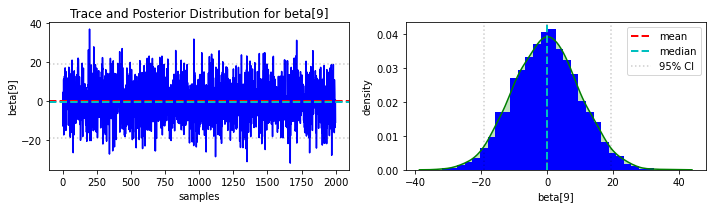

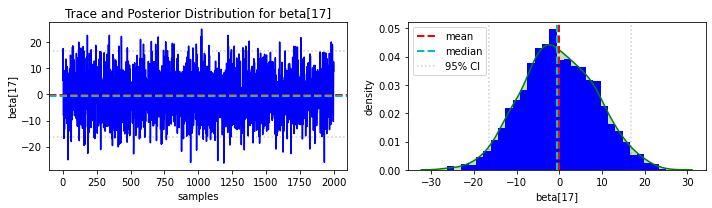

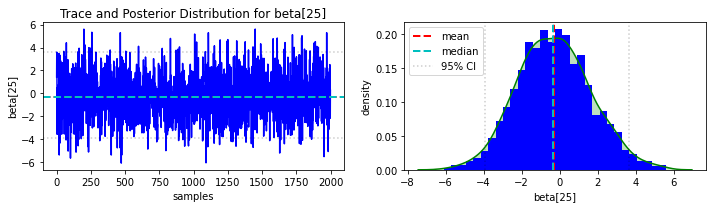

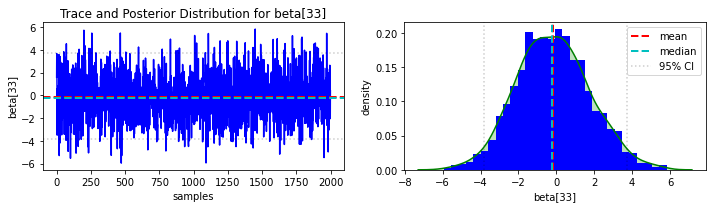

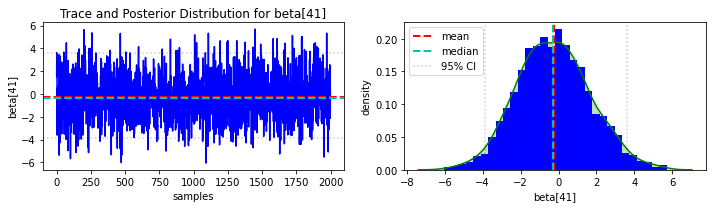

In [37]:
plt.rcParams["figure.figsize"]=(10,3)
pystan_utils.plot_trace(fit["alpha"],"alpha")
plt.show()
pystan_utils.plot_trace(fit["sigma"],"sigma")
plt.show()
for i in range(1,D,8):
    pystan_utils.plot_trace(fit["beta[%d]"%i],"beta[%d]"%i)
    plt.show()
    

### Prediction 

Given the posterior distributions over the variables alpha and beta, we can make predictions for the test set.

**Method 1:**

The output of STAN consists of samples from the posterior distribution of the latent variables. We can use these samples to compute the mean (or mode!) of the posterior distribution over alpha and beta ($\hat{\alpha}$ and $\hat{\boldsymbol\beta}$, respectively), and then use that mean/mode to make predictions $\hat{y}$ as follows:

$\hat{y}_n = \hat{\alpha} + \hat{\boldsymbol\beta}^T \textbf{x}_n$

Let's create a vector called "y_hat" with the predictions for the test set?

In [50]:
print("alpha shape: ", samples["alpha"].shape)
print("beta shape: ", samples["beta"].shape)
print("X_test shape: ", X_test.shape)

BB =samples["beta"].mean(axis=0)
y_hat=samples["alpha"].mean()+np.dot(X_test,BB)

print("y_hat shape: ", y_hat.shape )
print("beta samples mean shape: ", BB.shape)
y_hat

alpha shape:  (2000,)
beta shape:  (2000, 45)
X_test shape:  (21904, 45)
y_hat shape:  (21904,)
beta samples mean shape:  (45,)


array([-1.23067528, -1.01958852, -1.07207796, ...,  1.3141284 ,
        1.03461905,  1.25988202])

Since we standardized the target variable $y$ (number of taxi pickups) before feeding it to the STAN model, we need to convert the predictions back to original scale before evaluating their quality:

In [47]:
# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.641
MAE: 34.032
RMSE: 43.783
R2: 0.092


**Method 2:**

Indeed, the proper Bayesian way of making predictions for our Bayesian linear regression model is to follow the rules of probability. Namely, our goal in prediction is to use the posterior over $\alpha$ and $\boldsymbol\beta$ given the observed data, $p(\alpha | \textbf{y}, \textbf{X})$ and $p(\boldsymbol\beta | \textbf{y}, \textbf{X})$ respectively, to compute the posterior distribution of the target variable $y_*$ for a new input vector $\textbf{x}_*$ as follows:

$p(y_* | \textbf{x}_*, \textbf{y}, \textbf{X}, \sigma) = \int \int \mathcal{N}(y_* | \alpha + \boldsymbol\beta^T \textbf{x}_*, \sigma^2) \, p(\alpha | \textbf{y}, \textbf{X}) \, p(\boldsymbol\beta | \textbf{y}, \textbf{X}) \, d\alpha \, d\boldsymbol\beta$

Notice that we are integrating (or marginalizing) over all values of $\alpha$ and $\boldsymbol\beta$. We can think of this as averaging over the values of $\alpha$ and $\boldsymbol\beta$ according to their posterior distributions.

Since STAN outputs a set of $S$ samples from the posteriors, $\{\alpha^{(s)}, \boldsymbol\beta^{(s)}\}_{s=1}^S$, we can easily use them to approximate the expected value of $y_*$ as follows:

$\mathbb{E}[y_*] \approx \frac{1}{S} \sum_{s=1}^S \alpha^{(s)} + (\boldsymbol\beta^{(s)})^T \textbf{x}_*$

In [51]:
y_hat = np.mean(samples["alpha"].T + np.dot(X_test, samples["beta"].T), axis=1)
y_hat

array([-1.23067528, -1.01958852, -1.07207796, ...,  1.3141284 ,
        1.03461905,  1.25988202])

In [49]:
# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.641
MAE: 34.032
RMSE: 43.783
R2: 0.092


### STAN: Train on full dataset using ADVI (Automatic Differentiation Variational Inference)
MCMC methods have great properties, namely the fact that in the limit of infinite computation time they will converge to the true posterior distribution. However, they often have difficulty scaling to larger datasets. 

ADVI on the other hand is much more scalable. Let us now try to use ADVI to perform inference in our model

In [52]:
%%time
# prepare data for Stan model
N, D = X_train.shape
data = {'N': N, 'D': D, 'X': X_train, 'y': y_train}
fit = sm.vb(data=data, iter=10000, algorithm="fullrank", grad_samples=10, seed=42, verbose=True)

Wall time: 1h 15min 38s


Using `vb_extract_variable` function to extract the mean values of the posteriors:

In [66]:
alpha = pystan_utils.vb_extract_variable(fit, "alpha", var_type="real")
print("alpha:", alpha)

beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="vector")
print("beta:", beta)

alpha: -0.0021351431562462277
beta: [-2.48728551e-02  2.83366155e-02  2.83241897e-03 -3.12364908e-03
  5.62793823e-04  1.35978171e-02 -6.50782166e-03 -9.96951771e-03
 -7.97200140e-03 -1.39894198e-03 -5.38002839e-03 -1.25426120e-02
  1.30320639e-01  1.35844985e-01  1.52082302e-01  1.62178503e-01
  1.61225431e-01  1.49384158e-01  1.03530134e-01 -1.67735375e-01
 -1.96239356e-01 -1.86427317e-01 -1.71075704e-01 -1.46806155e-01
 -1.31475448e-01 -6.64808889e-03  2.26610569e-03  3.34507326e-02
 -1.19647304e-01 -1.12855042e-01 -4.90026951e-02 -5.67250658e-02
 -7.10338665e-02 -7.56482426e-02 -1.24476859e-01 -1.49370309e-01
  1.68545507e-02  3.01572216e-02 -4.49529774e-02 -3.40932439e-02
 -5.22809273e-02 -1.14569410e-01 -1.38115052e-01  8.70665847e-01
 -1.10601630e-01]


Using `report` function as a more direct way (but more verbose) option for extracting the mean values of the posteriors:

In [67]:
pystan_utils.report(fit, 'alpha')
pystan_utils.report(fit, 'beta')
pystan_utils.report(fit, 'sigma')

alpha = -0.0021351431562462277
beta[1] = -0.02487285512171808
beta[2] = 0.02833661553702251
beta[3] = 0.0028324189662906904
beta[4] = -0.0031236490812221475
beta[5] = 0.0005627938231558792
beta[6] = 0.0135978171310626
beta[7] = -0.00650782166066188
beta[8] = -0.00996951771422682
beta[9] = -0.007972001399389453
beta[10] = -0.0013989419800451517
beta[11] = -0.005380028388770917
beta[12] = -0.01254261202739528
beta[13] = 0.13032063870741886
beta[14] = 0.13584498518822302
beta[15] = 0.1520823017189324
beta[16] = 0.16217850257827088
beta[17] = 0.16122543065043593
beta[18] = 0.14938415787185785
beta[19] = 0.10353013360414592
beta[20] = -0.16773537548346545
beta[21] = -0.19623935574013693
beta[22] = -0.1864273166692004
beta[23] = -0.17107570355277316
beta[24] = -0.14680615488653537
beta[25] = -0.13147544825229535
beta[26] = -0.006648088893967186
beta[27] = 0.0022661056874944624
beta[28] = 0.03345073255084423
beta[29] = -0.1196473035095705
beta[30] = -0.11285504217562375
beta[31] = -0.04900269

Lets look at the posterior distributions of betas using `vb_plot_variables` function:

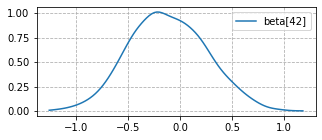

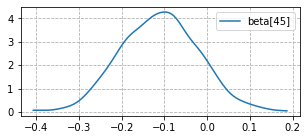

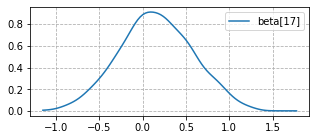

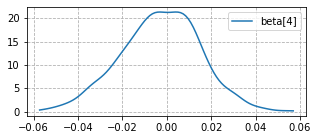

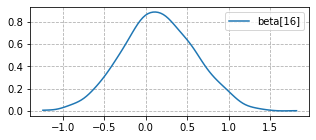

In [65]:
var_names = fit["sampler_param_names"][:-1]
random_select = list(np.random.choice(var_names,5))
for var_name in random_select:
    plt.figure(figsize=(5,2))
    plt.grid(linestyle="--")
    pystan_utils.vb_plot_variables(fit, str(var_name))
                          

Using the estimated values, we can make predictions for the test set:

In [68]:
y_hat = alpha + np.dot(X_test, beta)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))


CorrCoef: 0.916
MAE: 13.866
RMSE: 18.432
R2: 0.839


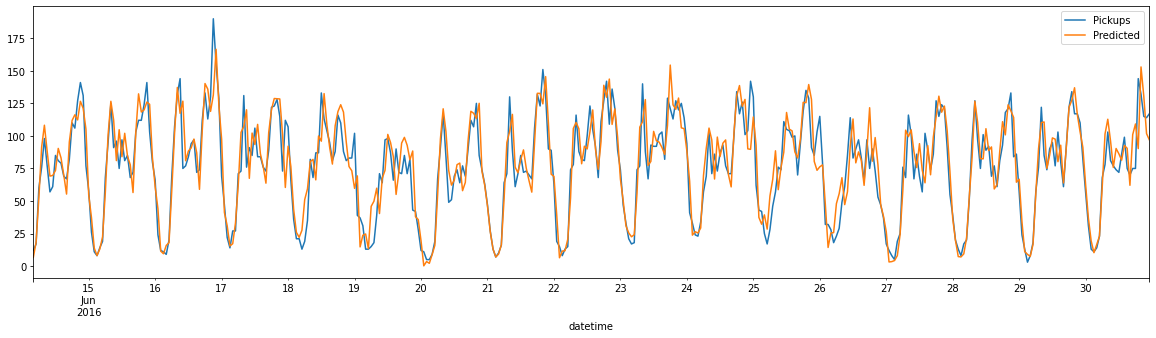

In [69]:
test_dataset = pd.DataFrame({"Pickups":y_true.flatten(),"Predicted":preds}).set_index(new_df.index[split:])
test_dataset.iloc[21500:,:].plot(figsize=(20,5));